<a href="https://colab.research.google.com/github/Danila565/Diploma/blob/main/CNN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
!pip install navec
!pip install pymorphy2
!pip install keras_preprocessing

In [4]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Embedding, GlobalMaxPooling1D, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from navec import Navec
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

In [5]:
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import re

In [6]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load the data
df = pd.read_csv("/content/drive/MyDrive/Диплом/90000_preprocess.csv")

In [ ]:
df2.drop(columns=['preprocess', 'tweet_text'], inplace=True)
df2.rename(columns={'augmented_text':'tweet_text'}, inplace=True)
df2.head()

,tweet_id,label,tweet_text
0,43941.0,2,"['Интересный. вакцин Если в регионах хватает, ..."
1,61807.0,2,['В - мои 19 все комиссионные снижены теперь н...
2,82914.0,2,['Наша собственная Майнор Кристи рассказывает ...
3,58912.0,2,['Всегда # Plymouth нравился https: / / t. co ...
4,170721.0,2,"['[ | Виктор ], волнуйтесь не придет британска..."


In [9]:
navec_model  = Navec.load('/content/drive/MyDrive/Диплом/navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def preprocess_text(text):
    text = re.sub(patterns, ' ', text)
    words = text.lower().split()
    words = [morph.parse(word)[0].normal_form for word in words]
    words = [word for word in words if word not in stopwords_ru]
    return ' '.join(words)

df['preprocess'] = df['tweet_text'].apply(preprocess_text)

In [ ]:
df['preprocess'] = df['tweet_text'].apply(preprocess_text)

In [ ]:
df.to_csv('/content/drive/MyDrive/Диплом/90000_preprocess.csv', index=False)

In [ ]:
df = df.dropna()

In [ ]:
import matplotlib.pyplot as plt

# создаем список длин строк из столбца dataframe
string_lengths = [len(i) for i in df['preprocess']]

In [ ]:
len(string_lengths)

90164

In [ ]:
cnt = 0
for i in string_lengths:
  if i <= 400:
    cnt += 1
print(cnt / 90164)

0.9943325495763276


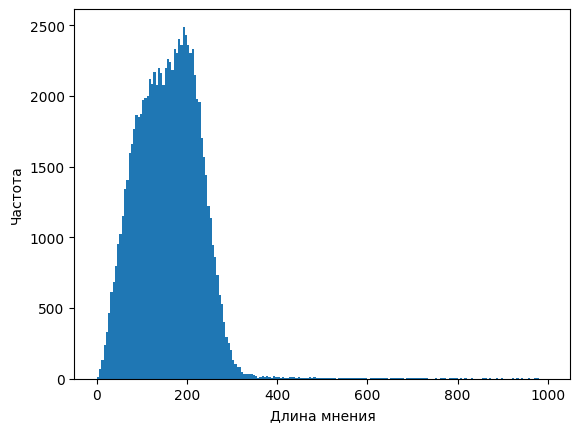

In [ ]:
# строим гистограмму
plt.hist(string_lengths, bins=200, range=(0,1000))
plt.xlabel('Длина мнения')
plt.ylabel('Частота')
plt.show()

In [10]:
# Preprocess the text data
tokenizer = Tokenizer(num_words=70000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['preprocess'])
sequences = tokenizer.texts_to_sequences(df['preprocess'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_len = 400
data = pad_sequences(sequences, maxlen=max_len)
y = to_categorical(df['label'])

Found 101741 unique tokens.


In [11]:
# Convert the embeddings to a matrix
embedding_dim = 300
num_words = min(70000, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = navec_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:
# Split the data into train and test sets
X_train, data, y_train, y_test = train_test_split(df['preprocess'], df['label'], test_size=0.2, random_state=42)

In [33]:
seq1 = tokenizer.texts_to_sequences(data)
X_test = pad_sequences(seq1, maxlen=max_len)

In [36]:
y_test

68453    2
72016    0
33739    2
35708    0
15766    1
        ..
13446    0
53012    2
85013    1
43616    0
53104    1
Name: label, Length: 18033, dtype: int64

In [28]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, df['label'], test_size=0.2, random_state=42)

In [13]:
# One-hot encode the labels
y = to_categorical(df['label'])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_test.sum(axis=0)

array([3281., 2505., 3231.], dtype=float32)

In [ ]:
# Define the model architecture
model4 = Sequential()
model4.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))
model4.add(Dropout(0.3))
model4.add(Conv1D(400, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model4.add(MaxPooling1D(pool_size=3))
model4.add(Conv1D(200, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model4.add(MaxPooling1D(pool_size=3))
model4.add(Flatten())
model4.add(Dropout(0.3))
model4.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model4.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model4.add(Dropout(0.3))
model4.add(Dense(3, activation='softmax'))
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])

In [ ]:
history4 = model4.fit(X_train, y_train, validation_split=0.2, epochs=11, batch_size=96) 

Epoch 1/11
677/677 [==============================] - 87s 123ms/step - loss: 1.1497 - cat_accuracy: 0.6141 - recall: 0.4683 - precision: 0.7007 - val_loss: 0.8656 - val_cat_accuracy: 0.7044 - val_recall: 0.6290 - val_precision: 0.7521
Epoch 2/11
677/677 [==============================] - 58s 85ms/step - loss: 0.7661 - cat_accuracy: 0.7454 - recall: 0.6954 - precision: 0.7803 - val_loss: 0.7225 - val_cat_accuracy: 0.7573 - val_recall: 0.7201 - val_precision: 0.7860
Epoch 3/11
677/677 [==============================] - 52s 78ms/step - loss: 0.5890 - cat_accuracy: 0.8204 - recall: 0.7943 - precision: 0.8414 - val_loss: 0.6555 - val_cat_accuracy: 0.7892 - val_recall: 0.7669 - val_precision: 0.8099
Epoch 4/11
677/677 [==============================] - 53s 78ms/step - loss: 0.4617 - cat_accuracy: 0.8707 - recall: 0.8551 - precision: 0.8866 - val_loss: 0.6092 - val_cat_accuracy: 0.8122 - val_recall: 0.7935 - val_precision: 0.8308
Epoch 5/11
677/677 [==============================] - 50s 74ms/

In [ ]:
# Define the model architecture
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow_addons as tfa

In [16]:
# Define the model architecture
model5 = Sequential()
model5.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))
model5.add(Dropout(0.3))
model5.add(Conv1D(400, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model5.add(GlobalMaxPooling1D())
model5.add(Dropout(0.3))
model5.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model5.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model5.add(Dropout(0.3))
model5.add(Dense(3, activation='softmax'))
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'), tfa.metrics.F1Score(name='f1-score', num_classes=3)])

In [17]:
# Train the model
history5 = model5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=96)

Epoch 1/10
752/752 [==============================] - 104s 110ms/step - loss: 1.3528 - cat_accuracy: 0.5847 - recall: 0.4170 - precision: 0.6806 - f1-score: 0.5789 - val_loss: 1.0126 - val_cat_accuracy: 0.6922 - val_recall: 0.6061 - val_precision: 0.7477 - val_f1-score: 0.6904
Epoch 2/10
752/752 [==============================] - 47s 62ms/step - loss: 0.9058 - cat_accuracy: 0.7157 - recall: 0.6496 - precision: 0.7582 - f1-score: 0.7126 - val_loss: 0.7961 - val_cat_accuracy: 0.7469 - val_recall: 0.6979 - val_precision: 0.7814 - val_f1-score: 0.7459
Epoch 3/10
752/752 [==============================] - 43s 57ms/step - loss: 0.7131 - cat_accuracy: 0.7842 - recall: 0.7439 - precision: 0.8144 - f1-score: 0.7828 - val_loss: 0.6921 - val_cat_accuracy: 0.7894 - val_recall: 0.7551 - val_precision: 0.8167 - val_f1-score: 0.7885
Epoch 4/10
752/752 [==============================] - 39s 52ms/step - loss: 0.5661 - cat_accuracy: 0.8437 - recall: 0.8198 - precision: 0.8649 - f1-score: 0.8434 - val_lo

In [149]:
model5.save('/content/drive/MyDrive/Диплом/model5')

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [37]:
y_pred = model5.predict(X_test)

564/564 [==============================] - 2s 4ms/step


In [38]:
predicted_labels = np.argmax(y_pred, axis=1)

In [39]:
predicted_labels

array([2, 0, 2, ..., 1, 0, 1])

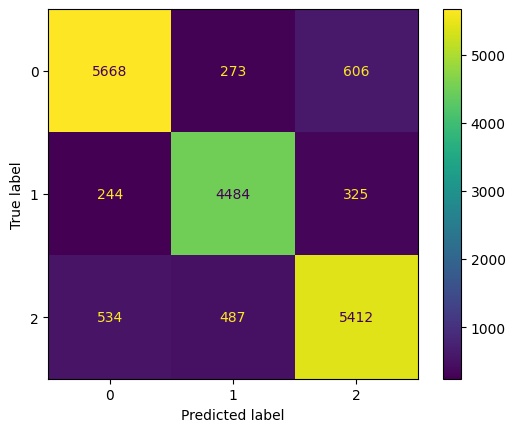

In [40]:
ConfusionMatrixDisplay.from_predictions(y_test, predicted_labels)
plt.show()

In [151]:
4484 / 5053

0.8873936275479913

In [152]:
5668 / 6547

0.865740033603177

In [153]:
5412 / 6433

0.8412871133219337

In [154]:
mat = confusion_matrix(y_test, predicted_labels)

In [156]:
type(mat)

numpy.ndarray

In [68]:
preds = pd.Series(predicted_labels)
labs = pd.Series(y_test)

In [86]:
frame = {'preprocess': data,
         'true': labs, 'pred': preds}

In [150]:
labs.value_counts()

0    6547
2    6433
1    5053
Name: label, dtype: int64

In [82]:
preds.index = labs.index

In [87]:
test_df = pd.DataFrame(frame, index = preds.index)

In [57]:
test_df['preprocess'] = data

In [92]:
test_df.shape

(18033, 3)

In [ ]:
temp1 = test_df[test_df.pred == 0]
temp2 = temp1[temp1.true == 2]
for i in temp2.sample(frac=0.01)['preprocess']:
  print(i)
  print()

In [146]:
temp2.shape

(760, 3)

In [ ]:
# Define the model architecture
model3 = Sequential()
model3.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model3.add(Dropout(0.3))
model3.add(Conv1D(400, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.3))
model3.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model3.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model3.add(Dropout(0.3))
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
# Train the model
history3 = model3.fit(X_train, y_train, validation_split=0.2, epochs=11, batch_size=96) 

Epoch 1/11
677/677 [==============================] - 22s 30ms/step - loss: 1.4301 - categorical_accuracy: 0.5485 - recall_5: 0.3522 - precision_5: 0.6505 - val_loss: 1.1525 - val_categorical_accuracy: 0.6269 - val_recall_5: 0.5221 - val_precision_5: 0.6964
Epoch 2/11
677/677 [==============================] - 20s 30ms/step - loss: 1.0675 - categorical_accuracy: 0.6379 - recall_5: 0.5285 - precision_5: 0.7025 - val_loss: 0.9784 - val_categorical_accuracy: 0.6555 - val_recall_5: 0.5701 - val_precision_5: 0.7115
Epoch 3/11
677/677 [==============================] - 20s 29ms/step - loss: 0.9557 - categorical_accuracy: 0.6612 - recall_5: 0.5688 - precision_5: 0.7178 - val_loss: 0.8933 - val_categorical_accuracy: 0.6866 - val_recall_5: 0.5969 - val_precision_5: 0.7422
Epoch 4/11
677/677 [==============================] - 21s 31ms/step - loss: 0.9113 - categorical_accuracy: 0.6728 - recall_5: 0.5874 - precision_5: 0.7247 - val_loss: 0.8736 - val_categorical_accuracy: 0.6932 - val_recall_5: 0

In [ ]:
# Evaluate the model on the test set
loss, accuracy, recall, precision = model3.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)
print('Test recall:', recall)
print('Test precision:', precision)

282/282 [==============================] - 2s 6ms/step - loss: 0.8618 - categorical_accuracy: 0.7091 - recall_5: 0.6652 - precision_5: 0.7415
Test accuracy: 0.7091050148010254
Test recall: 0.6651879549026489
Test precision: 0.7415007948875427


In [ ]:
# Define the model architecture
model_RMSprop = Sequential()
model_RMSprop.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))
model_RMSprop.add(Dropout(0.3))
model_RMSprop.add(Conv1D(400, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_RMSprop.add(GlobalMaxPooling1D())
model_RMSprop.add(Dropout(0.3))
model_RMSprop.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_RMSprop.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_RMSprop.add(Dropout(0.3))
model_RMSprop.add(Dense(3, activation='softmax'))
model_RMSprop.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005), loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
# Train the model
history_RMSprop = model_RMSprop.fit(X_train, y_train, validation_split=0.2, epochs=11, batch_size=96) 

Epoch 1/11
677/677 [==============================] - 67s 96ms/step - loss: 1.3780 - categorical_accuracy: 0.5586 - recall_8: 0.3696 - precision_8: 0.6561 - val_loss: 1.0804 - val_categorical_accuracy: 0.6436 - val_recall_8: 0.5359 - val_precision_8: 0.7116
Epoch 2/11
677/677 [==============================] - 36s 53ms/step - loss: 0.9901 - categorical_accuracy: 0.6608 - recall_8: 0.5662 - precision_8: 0.7176 - val_loss: 0.9041 - val_categorical_accuracy: 0.6835 - val_recall_8: 0.6107 - val_precision_8: 0.7347
Epoch 3/11
677/677 [==============================] - 33s 49ms/step - loss: 0.8764 - categorical_accuracy: 0.6919 - recall_8: 0.6177 - precision_8: 0.7413 - val_loss: 0.8406 - val_categorical_accuracy: 0.7017 - val_recall_8: 0.6463 - val_precision_8: 0.7362
Epoch 4/11
677/677 [==============================] - 34s 50ms/step - loss: 0.8203 - categorical_accuracy: 0.7131 - recall_8: 0.6481 - precision_8: 0.7546 - val_loss: 0.7903 - val_categorical_accuracy: 0.7273 - val_recall_8: 0

In [ ]:
# Train the model
history_RMSprop = model_RMSprop.fit(X_train, y_train, validation_split=0.2, epochs=4, batch_size=96) 

Epoch 1/4
677/677 [==============================] - 29s 43ms/step - loss: 0.6684 - categorical_accuracy: 0.7970 - recall_8: 0.7667 - precision_8: 0.8232 - val_loss: 0.7615 - val_categorical_accuracy: 0.7616 - val_recall_8: 0.7309 - val_precision_8: 0.7820
Epoch 2/4
677/677 [==============================] - 29s 43ms/step - loss: 0.6561 - categorical_accuracy: 0.8044 - recall_8: 0.7747 - precision_8: 0.8293 - val_loss: 0.7395 - val_categorical_accuracy: 0.7689 - val_recall_8: 0.7442 - val_precision_8: 0.7924
Epoch 3/4
677/677 [==============================] - 28s 42ms/step - loss: 0.6455 - categorical_accuracy: 0.8114 - recall_8: 0.7831 - precision_8: 0.8349 - val_loss: 0.7485 - val_categorical_accuracy: 0.7675 - val_recall_8: 0.7389 - val_precision_8: 0.7907
Epoch 4/4
677/677 [==============================] - 29s 43ms/step - loss: 0.6354 - categorical_accuracy: 0.8174 - recall_8: 0.7910 - precision_8: 0.8388 - val_loss: 0.7929 - val_categorical_accuracy: 0.7569 - val_recall_8: 0.727

In [ ]:
# Define the model architecture
model2 = Sequential()
model2.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))
model2.add(Dropout(0.3))
model2.add(Conv1D(400, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.3))
model2.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(Dropout(0.3))
model2.add(Dense(3, activation='softmax'))
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'), tfa.metrics.F1Score(name='f1-score', num_classes=3)])

In [ ]:
# Train the model
history2 = model2.fit(X_train, y_train, validation_split=0.2, epochs=11, batch_size=96) 

Epoch 1/11
677/677 [==============================] - 73s 104ms/step - loss: 1.3856 - cat_accuracy: 0.5769 - recall: 0.3969 - precision: 0.6751 - f1-score: 0.5701 - val_loss: 1.0427 - val_cat_accuracy: 0.6940 - val_recall: 0.6100 - val_precision: 0.7503 - val_f1-score: 0.6904
Epoch 2/11
677/677 [==============================] - 42s 62ms/step - loss: 0.9467 - cat_accuracy: 0.7096 - recall: 0.6421 - precision: 0.7525 - f1-score: 0.7061 - val_loss: 0.8432 - val_cat_accuracy: 0.7352 - val_recall: 0.6863 - val_precision: 0.7683 - val_f1-score: 0.7338
Epoch 3/11
677/677 [==============================] - 39s 58ms/step - loss: 0.7534 - cat_accuracy: 0.7724 - recall: 0.7308 - precision: 0.8028 - f1-score: 0.7705 - val_loss: 0.7410 - val_cat_accuracy: 0.7704 - val_recall: 0.7280 - val_precision: 0.8037 - val_f1-score: 0.7695
Epoch 4/11
677/677 [==============================] - 38s 57ms/step - loss: 0.6030 - cat_accuracy: 0.8332 - recall: 0.8074 - precision: 0.8545 - f1-score: 0.8325 - val_los

In [ ]:
# Evaluate the model on the test set
loss, accuracy, recall, precision = model2.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)
print('Test recall:', recall)
print('Test precision:', precision)

282/282 [==============================] - 2s 6ms/step - loss: 0.6313 - categorical_accuracy: 0.8483 - recall_3: 0.8391 - precision_3: 0.8548
Test accuracy: 0.8482865691184998
Test recall: 0.8390817642211914
Test precision: 0.8548186421394348


In [ ]:
model2.save('/content/drive/MyDrive/Диплом/model400_70000nw_nonstatic')

In [ ]:
restored = load_model('/content/drive/MyDrive/Диплом/model400_70000nw_nonstatic')

In [ ]:
# Evaluate the model on the test set
loss, accuracy = restored.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

282/282 [==============================] - 2s 6ms/step - loss: 0.6450 - accuracy: 0.8470
Test accuracy: 0.8469557762145996


In [ ]:
model2.save('./models/non_static')

INFO:tensorflow:Assets written to: ./models/non_static\assets


INFO:tensorflow:Assets written to: ./models/non_static\assets


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
f1score_history_np = np.array(f1score_history)
val_f1score_history_np = np.array(val_f1score_history)

In [ ]:
A[:, 0]

array([0.622573  , 0.74671936, 0.80051994, 0.8510735 , 0.8872189 ,
       0.91113424, 0.92436695, 0.93470865, 0.94162166, 0.94958556],
      dtype=float32)

In [ ]:
# Получение истории значений функции потерь и точности
history2 = history5
loss_history = history2.history['loss']
val_accuracy_history = history2.history['val_cat_accuracy']
accuracy_history = history2.history['cat_accuracy']
val_recall_history = history2.history['val_recall']
recall_history = history2.history['recall']
val_precision_history = history2.history['val_precision']
precision_history = history2.history['precision']
val_f1score_history = history2.history['val_f1-score']
f1score_history = history2.history['f1-score']
# Создание массива шагов
epochs = range(1, len(loss_history) + 1)

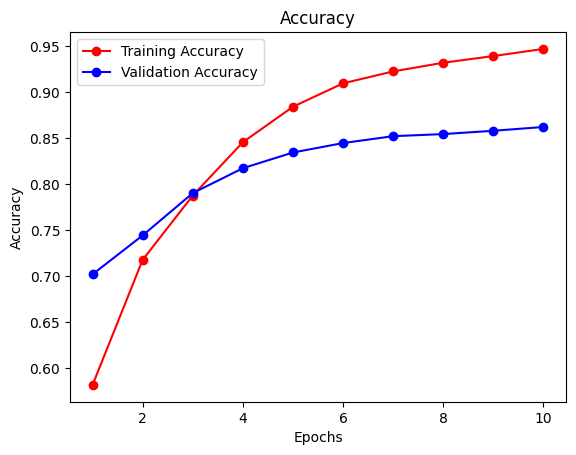

In [ ]:
# Построение графика изменения точности на валидационной выборке
plt.plot(epochs, accuracy_history, marker='o', color='r', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, marker='o', color='b', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

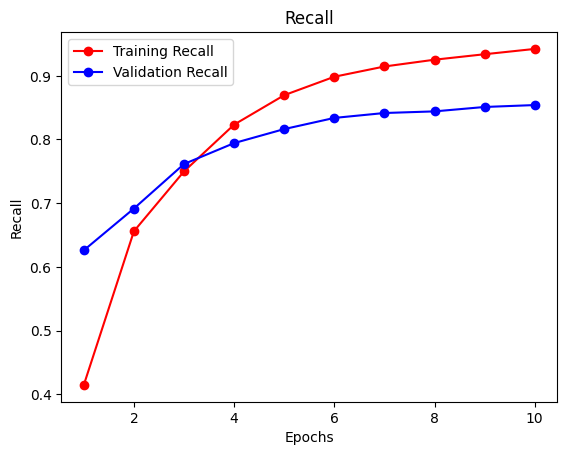

In [ ]:
# Построение графика изменения recall на обучающей выборке
plt.plot(epochs, recall_history, marker='o',  color='r', label='Training Recall')
plt.plot(epochs, val_recall_history, marker='o', color='b', label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

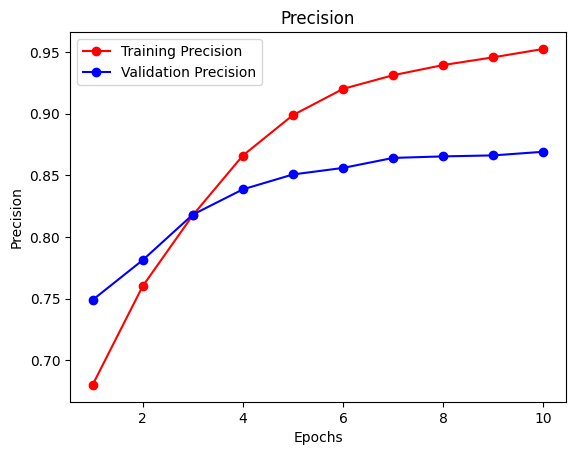

In [ ]:
# Построение графика изменения precision на обучающей выборке
plt.plot(epochs, precision_history, marker='o', color='r', label='Training Precision')
plt.plot(epochs, val_precision_history, marker='o', color='b', label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

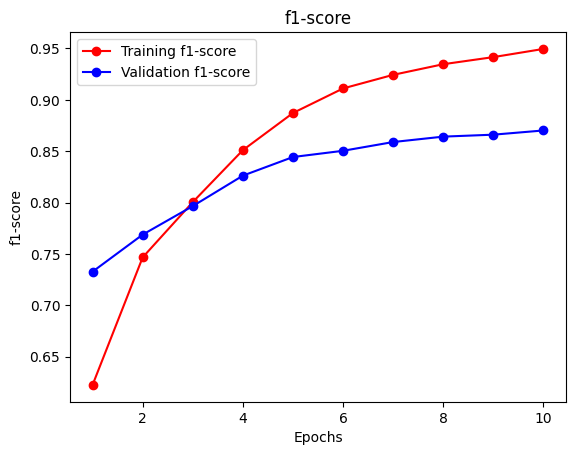

In [ ]:
# Построение графика изменения f1-score на обучающей выборке
plt.plot(epochs, f1score_history_np[:, 0], marker='o', color='r', label='Training f1-score')
plt.plot(epochs, val_f1score_history_np[:, 0], marker='o', color='b', label='Validation f1-score')
plt.title('f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

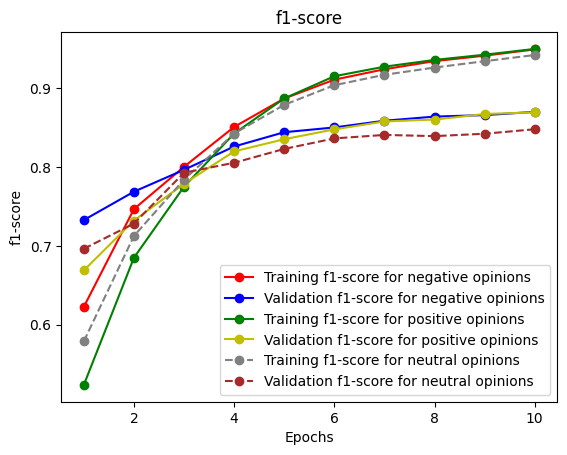

In [ ]:
# Построение графика изменения f1-score на обучающей выборке
plt.plot(epochs, f1score_history_np[:, 0], marker='o', color='r', label='Training f1-score for negative opinions')
plt.plot(epochs, val_f1score_history_np[:, 0], marker='o', color='b', label='Validation f1-score for negative opinions')
plt.plot(epochs, f1score_history_np[:, 1], marker='o', color='g', label='Training f1-score for positive opinions')
plt.plot(epochs, val_f1score_history_np[:, 1], marker='o', color='y', label='Validation f1-score for positive opinions')
plt.plot(epochs, f1score_history_np[:, 2], linestyle='dashed', marker='o', color='grey', label='Training f1-score for neutral opinions')
plt.plot(epochs, val_f1score_history_np[:, 2], linestyle='dashed', marker='o', color='brown', label='Validation f1-score for neutral opinions')
plt.title('f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

In [18]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.1 MB/s eta 0:00:00


In [19]:
import pandas as pd
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf

In [20]:
df.label.value_counts()

0    32886
2    32395
1    24883
Name: label, dtype: int64

In [ ]:
df.shape

(90164, 4)

In [ ]:
df1 = df[df.label == 1].sample(frac=1, ignore_index=True)
df1.shape

(12454, 4)

In [22]:
df1 = df.sample(frac=0.1, ignore_index=True)
df1['label'].value_counts()

2    3278
0    3268
1    2470
Name: label, dtype: int64

In [ ]:
!gzip -d /content/drive/MyDrive/Диплом/ppdb-1.0-xxxl-ccg.gz

In [ ]:
# Initialize the augmentation object

#aug = naw.SynonymAug(aug_src='ppdb', model_path='/content/drive/MyDrive/Диплом/ppdb-1.0-xxxl-ccg', aug_p=1, lang='rus')

# Define the augmentation flow
flow = naf.Sequential([
    naw.RandomWordAug(action='delete', aug_p=0.1),
    naw.RandomWordAug(action='swap', aug_p=0.2)
])

# Define the function to apply augmentation to text data
def augment_text(text):
    return flow.augment(text)

# Add a new column to the dataframe with augmented text
df1['augmented_text'] = df1['tweet_text'].apply(augment_text)

In [ ]:
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf

# Define the augmentation flow
flow = naf.Sequential([
    naw.RandomWordAug(action='delete', aug_p=0.1),
    naw.RandomWordAug(action='swap', aug_p=0.2)
])

# Define the function to apply augmentation to text data
def augment_text(text):
    return flow.augment(text)

# Add a new column to the dataframe with augmented text
df['augmented_text'] = df['tweet_text'].apply(augment_text)

In [ ]:
df1.shape

(12454, 5)

In [ ]:
df1.tweet_text[0]

In [ ]:
df1.augmented_text[0]

In [ ]:
# Save the augmented dataframe to a new CSV file
df1.to_csv('/content/drive/MyDrive/Диплом/aug1_12000.csv', index=False)